In [1]:
!pip install scikit-fda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.4 MB/s eta 0:00:00
  Created wheel for fdasrsf: filename=fdasrsf-2.5.10-cp310-cp310-linux_x86_64.whl size=3081574 sha256=914b2c1e146c7d53208e4f62de3915c1d0093fa890b054f7d3d3530b75feb678
  Stored in directory: /root/.cache/pip/wheels/e8/52/1c/c4c363a070fc6643f741e1e7ecaae39377bc19130052054270
Successfully built fdasrsf


In [46]:
from matplotlib import pyplot as plt

import skfda
import skfda.datasets
from skfda.exploratory.visualization import FPCAPlot
# from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
from skfda.misc.metrics import LpDistance

distance_func = LpDistance(p=2)

In [12]:
from scipy.linalg import solve_triangular
from sklearn.decomposition import PCA
import numpy as np
from skfda.representation import FDataBasis
from typing import Optional


class FPCA:
    """
    Считаем важным приложить ссылку на источник - https://fda.readthedocs.io/en/latest/auto_examples/plot_fpca.html
    С общей идеей можно ознакомиться в вики: https://en.wikipedia.org/wiki/Functional_principal_component_analysis
    Ещё про отличие от PCA можно почитать вот тут (особенно второй ответ): https://stats.stackexchange.com/questions/23566/functional-principal-component-analysis-fpca-what-is-it-all-about
    """
    DEFAULT_N_COMPONENTS = 3

    def __init__(
        self,
        n_components: Optional[int] = None,
        components_basis: Optional[FDataBasis] = None
    ) -> None:
        if n_components is None:
            n_components = FPCA.DEFAULT_N_COMPONENTS

        self.n_components = n_components
        self.components_basis = components_basis

    def _center(self, X, learn_mean: bool = True):
        if learn_mean:
            self.mean_ = X.mean()

        return X - self.mean_

    def fit(self, X: FDataBasis):
        """
        Больше про алгоритм можно посмотреть вот тут: https://www.psych.mcgill.ca/misc/fda/files/CRM-FPCA.pdf
        """
        assert isinstance(X, FDataBasis), "Dataset should be an instance of FDataBasis class"

        n_basis = (
            self.components_basis.n_basis
            if self.components_basis
            else X.basis.n_basis
        )

        self.n_samples_ = X.n_samples

        # Центрируем
        X = self._center(X)

        components_basis = self.components_basis
        if components_basis is not None:
            components_basis = components_basis.copy(
                domain_range=X.basis.domain_range,
            )
            g_matrix = components_basis.gram_matrix()
            # Берём матрицу скалярных произведений двух базисов
            j_matrix = X.basis.inner_product_matrix(components_basis)
        else:
            # Если не подали базис руками - возьмём тот же, что и в датасете
            components_basis = X.basis.copy()
            g_matrix = components_basis.gram_matrix()
            # В этом случае матрица скалярных произведений это матрица Грама
            j_matrix = g_matrix

        self._X_basis = X.basis
        self._j_matrix = j_matrix

        # Считаем L=G^1/2
        l_matrix = np.linalg.cholesky(g_matrix)

        # Тут считаем L^(-1)J^T
        l_inv_j_t = solve_triangular(
            l_matrix,
            np.transpose(j_matrix),
            lower=True,
        )

        # Считаем C(L^(-1)J^T)^T
        final_matrix = X.coefficients @ np.transpose(l_inv_j_t)

        pca = PCA(n_components=self.n_components)
        pca.fit(final_matrix)

        # будем иметь (L^(-1)J^T)C^TC(L^(-1)J^T)^T
        component_coefficients = solve_triangular(
            np.transpose(l_matrix),
            np.transpose(pca.components_),
            lower=False,
        )

        self.explained_variance_ratio_ = (
            pca.explained_variance_ratio_
        )
        self.explained_variance_ = pca.explained_variance_
        self.singular_values_ = pca.singular_values_
        self.components_: FDataBasis = X.copy(
            basis=components_basis,
            coefficients=component_coefficients.T,
            sample_names=(None,) * self.n_components,
        )

        return self

    def transform(self, X: FDataBasis):
        """
        По датасету строим скоры компонент.
        """
        assert isinstance(X, FDataBasis), "Dataset should be an instance of FDataBasis class"
        assert X.basis == self._X_basis, "The basis used in fit should be the same as the basis used in transform."

        X = self._center(X, learn_mean=False)

        return X.coefficients @ self._j_matrix @ self.components_.coefficients.T

    def fit_transform(self, X: FDataBasis):
        return self.fit(X).transform(X)

    def inverse_transform(self, pc_scores) -> FDataBasis:
        return (
            self.mean_.copy(
                coefficients=pc_scores @ self.components_.coefficients,
                sample_names=(None,) * len(pc_scores),
            )
            + self.mean_
        )

### Попробуем на датасете Canadian Weather, по оси x указано время, по оси y - осадки в мм для 35 городов Канады.
Подробнее можно почитать вот тут: https://search.r-project.org/CRAN/refmans/gamair/html/canWeather.html

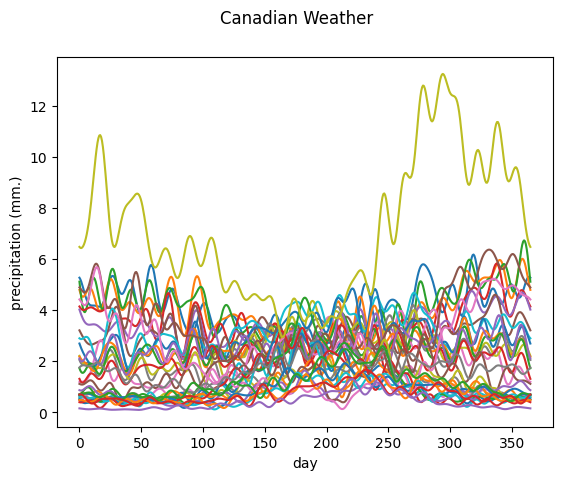

In [30]:
X, _ = skfda.datasets.fetch_weather(return_X_y=True)
# X[0].plot()
# y = dataset['target']
# fd.plot()
X = X.coordinates[1]
X_basis = X.to_basis(FourierBasis(n_basis=50))
X_basis.plot()
plt.show()

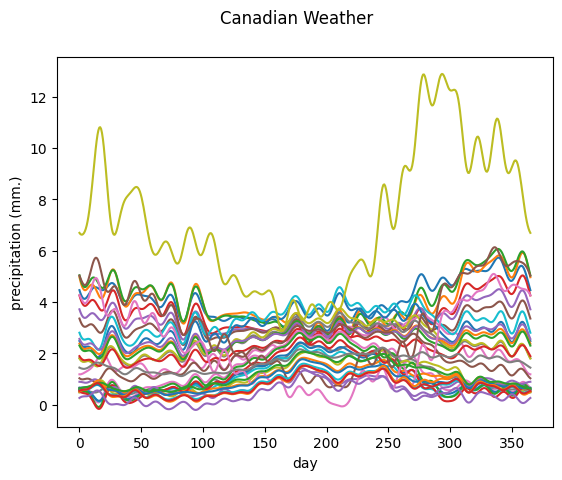

In [47]:
fpca_model = FPCA(n_components=3)
pc_scores = fpca_model.fit_transform(X_basis)
inverse = fpca_model.inverse_transform(pc_scores)
inverse.plot()
plt.show()

### Повысим количество компонент

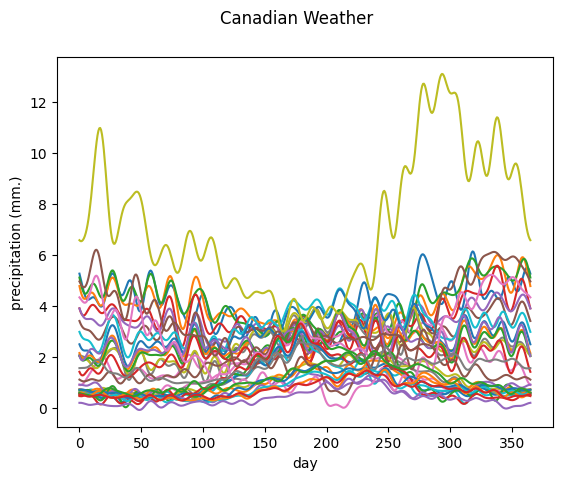

In [48]:
fpca_model = FPCA(n_components=7)
pc_scores = fpca_model.fit_transform(X_basis)
inverse = fpca_model.inverse_transform(pc_scores)
inverse.plot()
plt.show()

Что ж, функции стали раскрываться детальнее.

Попробуем изобразить зависимость $\int(X(t) - X_m(t))^2dt$ от $m$. Согласно [статье](https://en.wikipedia.org/wiki/Functional_principal_component_analysis) оно равно $\sum_{j > m}\lambda_j \rightarrow 0$.

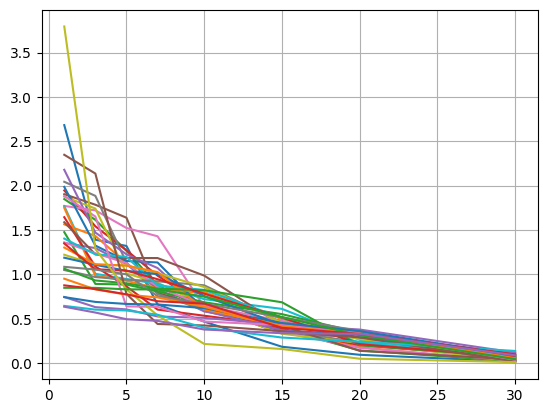

In [69]:
n_comps = [1, 3, 5, 7, 10, 15, 20, 30]
distances = []

for n_components in n_comps:
    fpca_model = FPCA(n_components=n_components)
    pc_scores = fpca_model.fit_transform(X_basis)
    inverse = fpca_model.inverse_transform(pc_scores)
    distances.append(distance_func(X_basis, inverse))

plt.plot(n_comps, distances)
plt.grid()
plt.show()

Ожидаемо, оно стремится к нулю при увеличении количества компонент.

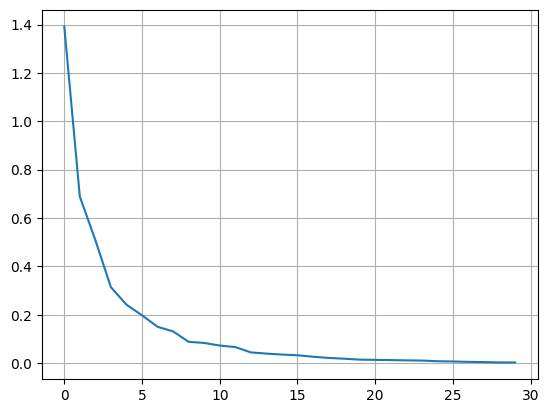

In [70]:
plt.plot(fpca_model.explained_variance_)
plt.grid()
plt.show()

### И попробуем на другом датасете (например, на датасете производных функций исходного датасета, это сделать легко)

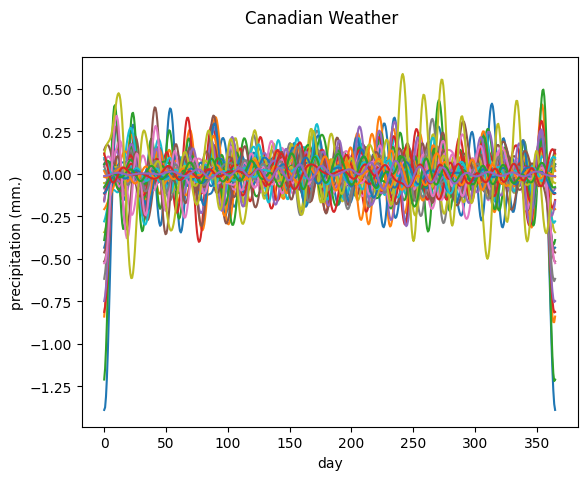

In [59]:
X, _ = skfda.datasets.fetch_weather(return_X_y=True)
# X[0].plot()
# y = dataset['target']
# fd.plot()
X = X.coordinates[1]
X_basis = X.derivative().to_basis(FourierBasis(n_basis=50))
X_basis.plot()
plt.show()

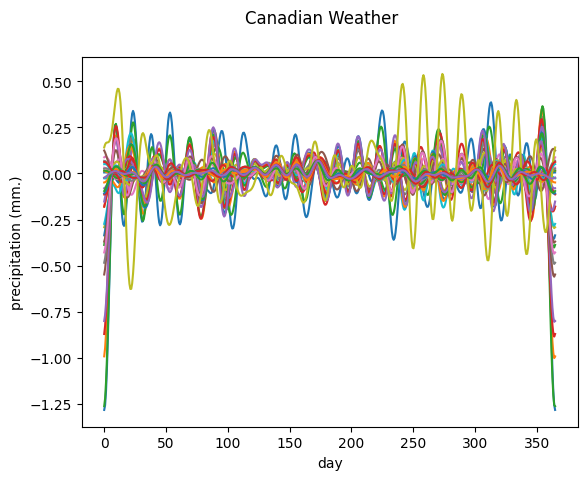

In [60]:
fpca_model = FPCA(n_components=3)
pc_scores = fpca_model.fit_transform(X_basis)
inverse = fpca_model.inverse_transform(pc_scores)
inverse.plot()
plt.show()

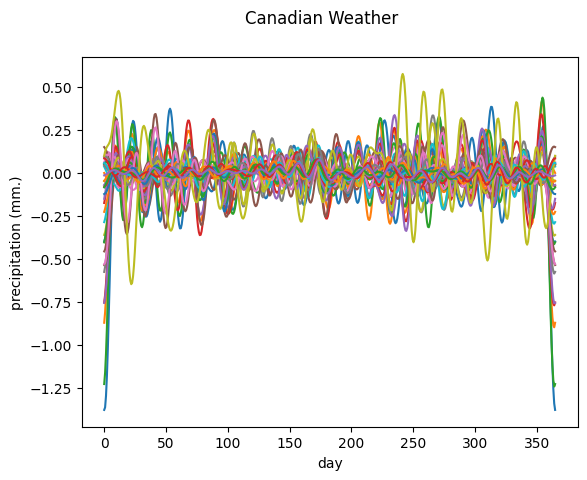

In [62]:
fpca_model = FPCA(n_components=7)
pc_scores = fpca_model.fit_transform(X_basis)
inverse = fpca_model.inverse_transform(pc_scores)
inverse.plot()
plt.show()